# Cálculo da Viscosidade

Por *Victor Côrtes* e *Mariana Hoyer*

# Sumário

[Objetivo](#Objetivo:)

[Importando bibliotecas](#Importando-bibliotecas)

[A Simulação de dinâmica molecular](#A-Simulação-de-dinâmica-molecular)

[Implementação do Método Maginn para calcular a Viscosidade](#Implementação-do-Método-Maginn-para-calcular-a-Viscosidade)

[Método de Decomposição do Tempo para o Cálculo de Viscosidade.](#Método-de-Decomposição-do-Tempo-para-o-Cálculo-de-Viscosidade.)
    
   - [Procedimento de 5 etapas para o Cálculo da Viscosidade pelo Método Maginn](#Procedimento-de-5-etapas-para-o-C%C3%A1lculo-da-Viscosidade-pelo-M%C3%A9todo-Maginn)

     1. [Gerar N trajetórias NVT independentes em uma dada temperatura](#(1)-Gerar-N-trajet%C3%B3rias-NVT-independentes-em-uma-dada-temperatura:);

     1. [Para cada trajetória, calcule a viscosidade de cisalhamento com base na relação Green-Kubo (eq 1)](#(2)-Para-cada-trajet%C3%B3ria,-calcule-a-viscosidade-de-cisalhamento-com-base-na-rela%C3%A7%C3%A3o-Green-Kubo-(eq-1):);

     1. [Calcular a média das integrais em execução sobre N trajetórias ⟨$\eta$(t)⟩ e o desvio padrão, que é uma função do tempo](#(3)-Calcular-a-m%C3%A9dia-das-integrais-em-execu%C3%A7%C3%A3o-sobre-N-trajet%C3%B3rias-%E2%9F%A8$\eta$(t)%E2%9F%A9-e-o-desvio-padr%C3%A3o,-que-%C3%A9-uma-fun%C3%A7%C3%A3o-do-tempo:);
         - [Viscosidade Média](#Viscosidade-Média)
         - [Desvio Padrão](#Desvio-Padrão)

     1. [Ajuste o desvio padrão para uma função de lei de potência:](#(4)-Ajuste-o-desvio-padrão-para-uma-função-de-lei-de-potência:)

        \begin{equation}
            \sigma(t) = At^{b}
        \end{equation}

     1. [Ajustar a integral média em execução pela função dupla - exponencial (eq2) para o período de tempo até $t_{cut}$, que pode ser decidido a partir da relação entre $ \eta$ e $ \sigma(t) $. Descobrimos que o tempo em que $ \sigma(t)$ é cerca de 40% de $<\eta(t)>$ é uma boa escolha. Pegue o valor do limite com tempo tendendo a infinito da função double-exponencial ajustada como a viscosidade calculada](#(5)-Ajustar-a-integral-média-em-execução-pela-função-dupla---exponencial-(eq2)-para-o-período-de-tempo-até-$t_{cut}$,-que-pode-ser-decidido-a-partir-da-relação-entre-$-\eta$-e-$-\sigma(t)-$.-Descobrimos-que-o-tempo-em-que-$-\sigma(t)$-é-cerca-de-40%-de-$<\eta(t)>$-é-uma-boa-escolha.-Pegue-o-valor-do-limite-com-tempo-tendendo-a-infinito-da-função-double-exponencial-ajustada-a-viscosidade-calculada:);      
         - [Função Double-Exponencial](#Função-Double-Exponencial)
         - [Tempo $t_{cut}$](#Tempo-$t_{cut}:$)
         - [Conclusão](#Conclusão:)
     1. [Variação da Viscosidade Calculada e do erro conforme a variação da tolerância do desvio padrão](#Varia%C3%A7%C3%A3o-da-Viscosidade-Calculada-e-do-erro-conforme-a-varia%C3%A7%C3%A3o-da-toler%C3%A2ncia-do-desvio-padr%C3%A3o)
         - [Conclusão Otimizada](#Conclusão-Otimizada)


## Objetivo: 

Implementar um método de cálculo de viscosidade para calcular a do [Deep eutectic solvent](https://en.wikipedia.org/wiki/Deep_eutectic_solvent), usando:

- dados obtidos do [GROMACS](http://www.gromacs.org/) de simulações por dinâmica molecular de um sistema químico composto por Dodecanoato de sódio e ácido decanóico; 
- e a Metodologia Maginn apresentada no artigo *Reliable Viscosity Calculation from Equilibrium Molecular Dynamics Simulations: A Time Decomposition Method (DOI:10.1021/acs.jctc.5b00351)* para calcular a viscosidade de sistemas simulados.

## Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import simps
from scipy.optimize import curve_fit
from os import path
from IPython.display import Image, HTML
import logging
logger = logging.getLogger('ftpuploader')

## A Simulação de dinâmica molecular

De acordo com a dissertação *Modelação e simulação de sistemas envolvendo Deep Eutectic Solvents
e água – Estrutura, propriedades e extração de poluentes*, de Mariana Hoyer:

"*A escolha do método de simulação a ser aplicado depende principalmente do fenômeno a ser investigado e do sistema. Em simulações de sistemas líquidos, é preferível escolher simulação de dinâmica molecular, pois as conformações do sistema podem ser obtidas pela troca de energia decorrente das moléculas que colidem. Se a preferência fosse pelo método Monte Carlo, haveria uma elevada probabilidade de os movimentos aleatórios ocasionarem sobreposição de partículas, gerando muitas rejeições de movimentos e consequentemente, perda de eficiência da simulação. Além disso, para o cálculo de propriedades como viscosidade de um líquido, somente o método de dinâmica molecular é apropriado, porque diferentemente do método Monte Carlo, o tempo de simulação pode ser definido, possibilitando a obtenção de propriedades dependentes do tempo.*

"*As simulações de dinâmica molecular necessitam passar por uma etapa de minimização de energia para relaxação do sistema, evitando que a simulação comece muito distante do equilíbrio, o que poderia levar a um colapso do sistema. As equações
de Newton do movimento (1 e 2) são utilizadas para determinação das configurações dos sistemas com N átomos que interajam entre si:*

\begin{equation}
    m_i \frac{\partial^{2}r_i}{\partial t^2} = F_i, \quad i=1, ... ,N 
\end{equation}

\begin{equation}
    F_i = - \frac{\partial V}{\partial r_i} (2)
\end{equation}

" *Onde as forças são as derivadas negativas da função potencial V(r1, ...,rN).*

"*No decurso da simulação, as equações são resolvidas simultaneamente em pequenos passos de tempo, gerando coordenadas e velocidades ao longo dos intervalos regulares definidos. O conjunto de coordenadas e velocidades em função do tempo é denominado **trajetória** de uma simulação, sendo registada num ficheiro de saída apropriado. A escolha do passo de tempo adequado é importante para levar o sistema a uma configuração correta de equilíbrio, pois um passo muito curto torna a simulação demorada e um passo demasiado longo faz com que os cálculos das equações de Newton se desviem muito do que seria a solução de uma trajetória clássica correta e não se respeite o princípio da conservação de energia. Após atingir o estado de equilíbrio, é possível calcular várias propriedades macroscópicas do sistema pelas médias dos resultados gerados ao longo da trajetória subsequente.*"

**Trajetórias** correspondentes a diferentes simulações para um dado sistema não serão
iguais umas às outras. Isto ocorre porque cada simulação, a partir da sua própria
configuração inicial, percorrerá um caminho distinto, resultando num conjunto de
trajetórias divergentes, mesmo que a composição inicial do sistema seja a mesma. Ao
criar um sistema, as moléculas são inseridas de maneira aleatória, ocasionando em
configurações iniciais diferentes a cada vez que uma caixa é criada. Sendo assim, a fim
de se obter resultados estatisticamente relevantes, mais de uma trajetória é adquirida para
um dado sistema e os cálculos são feitos com a média das trajetórias

As condições periódicas de fronteira, apesar de serem uma limitação do método,
são aplicadas para minimizar efeitos de superfície em um sistema finito [29]. A caixa
contendo os átomos do sistema a ser simulado é rodeado por cópias transladadas de sua
própria caixa, conforme ilustrado na figura abaixo.

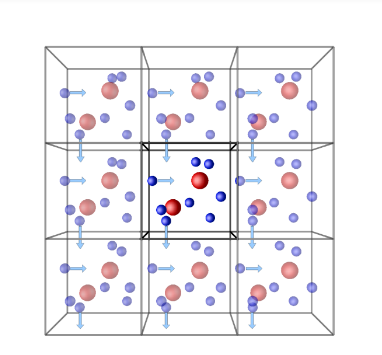

In [2]:
Image("Images/simulacao_3.png")

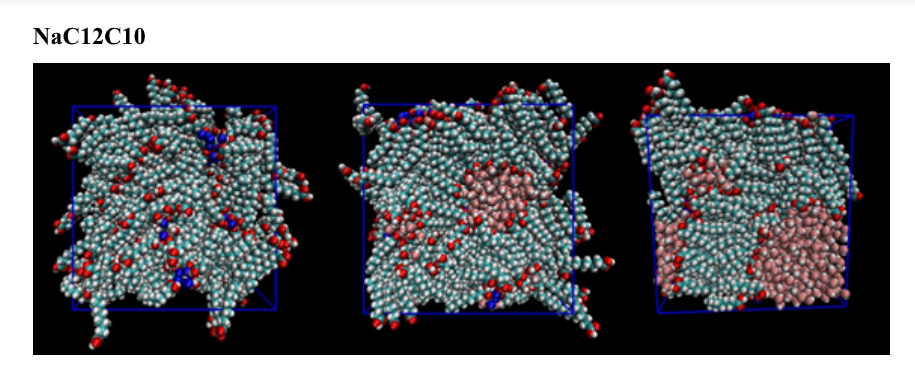

In [3]:
Image("Images/simulacao_1.png")

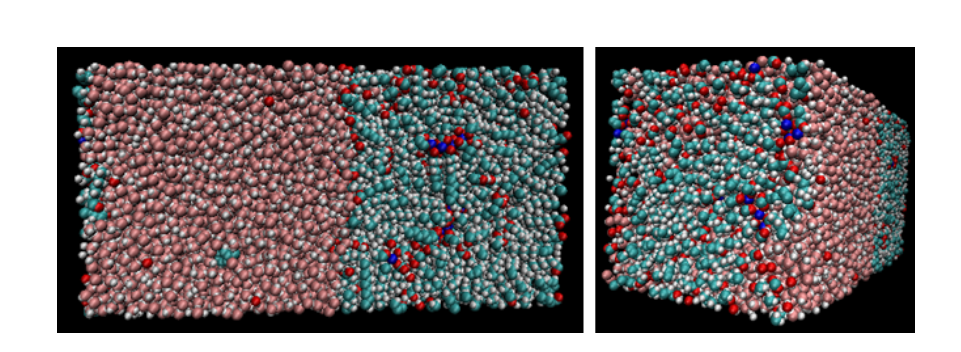

In [4]:
Image("Images/simulacao_2.png")

A simulação nos fornece os seis [tensores](https://pt.wikipedia.org/wiki/Tensor) correspondentes a cada trajetória, de coordenadas $[xx,xy,xz,yy,yz,zz]$

Eles serão usados pelo método que iremos implementar

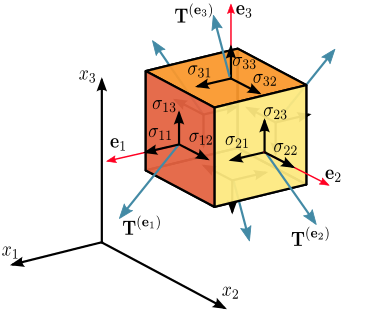

In [5]:
Image("Images/370px-Components_stress_tensor_cartesian.png")

## Implementação do Método Maginn para calcular a Viscosidade

Usaremos a Metodologia Maginn apresentada no artigo Reliable Viscosity Calculation from Equilibrium Molecular Dynamics Simulations: A Time Decomposition Method (DOI:10.1021/acs.jctc.5b00351) para calcular a viscosidade desses sistemas simulados.

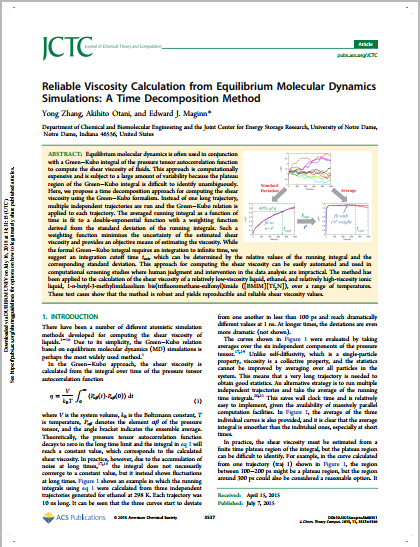

In [6]:
Image("Images/primeira_pagina_do_artigo.png")

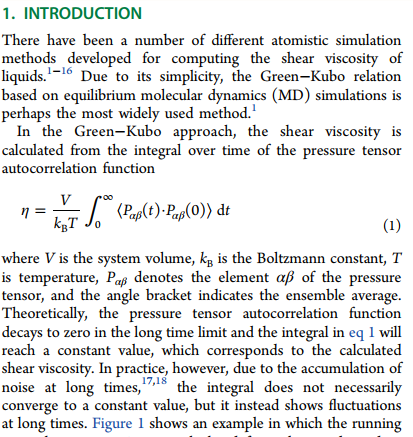

In [7]:
Image("Images/primeira_pagina_do_artigo_p1.png")

## Método de Decomposição do Tempo para o Cálculo de Viscosidade.

A viscosidade de cisalhamento foi calculada seguindo o procedimento abaixo:

### Procedimento de 5 etapas para o Cálculo da Viscosidade pelo Método Maginn

As 5 etapas são:

 1. [Gerar N trajetórias NVT independentes em uma dada temperatura](#(1)-Gerar-N-trajet%C3%B3rias-NVT-independentes-em-uma-dada-temperatura:);
 
 1. [Para cada trajetória, calcule a viscosidade de cisalhamento com base na relação Green-Kubo (eq 1)](#(2)-Para-cada-trajet%C3%B3ria,-calcule-a-viscosidade-de-cisalhamento-com-base-na-rela%C3%A7%C3%A3o-Green-Kubo-(eq-1):);
 
 1. [Calcular a média das integrais em execução sobre N trajetórias ⟨$\eta$(t)⟩ e o desvio padrão, que é uma função do tempo](#(3)-Calcular-a-m%C3%A9dia-das-integrais-em-execu%C3%A7%C3%A3o-sobre-N-trajet%C3%B3rias-%E2%9F%A8$\eta$(t)%E2%9F%A9-e-o-desvio-padr%C3%A3o,-que-%C3%A9-uma-fun%C3%A7%C3%A3o-do-tempo:);

 1. [Ajuste o desvio padrão para uma função de lei de potência:](#(4)-Ajuste-o-desvio-padrão-para-uma-função-de-lei-de-potência:)

    \begin{equation}
        \sigma(t) = At^{b}
    \end{equation}

 1. [Ajustar a integral média em execução pela função dupla - exponencial (eq2) para o período de tempo até $t_{cut}$, que pode ser decidido a partir da relação entre $ \eta$ e $ \sigma(t) $. Descobrimos que o tempo em que $ \sigma(t)$ é cerca de 40% de $<\eta(t)>$ é uma boa escolha. Pegue o valor do limite com tempo tendendo a infinito da função double-exponencial ajustada como a viscosidade calculada](#(5)-Ajustar-a-integral-média-em-execução-pela-função-dupla---exponencial-(eq2)-para-o-período-de-tempo-até-$t_{cut}$,-que-pode-ser-decidido-a-partir-da-relação-entre-$-\eta$-e-$-\sigma(t)-$.-Descobrimos-que-o-tempo-em-que-$-\sigma(t)$-é-cerca-de-40%-de-$<\eta(t)>$-é-uma-boa-escolha.-Pegue-o-valor-do-limite-com-tempo-tendendo-a-infinito-da-função-double-exponencial-ajustada-a-viscosidade-calculada:);
 
 

#### (1) Gerar N trajetórias NVT independentes em uma dada temperatura:

[Voltar ao índice das etapas](#Procedimento-de-5-etapas-para-o-Cálculo-da-Viscosidade-pelo-Método-Maginn)

Primeiro importaremos as trajetórias, provenientes das simulações do GROMACS, que serão usadas e selecionaremos quais são válidas para o cálculo da viscosidade.

No final das 5 etapas, o valor da viscosidade será o valor para o qual a média das integrais dos dados convergir(veremos o porquê disso mais a frente). Para que a integral convirja, os valores dos dados devem converjir para 0.

Então verificaremos quais dessas trajetórias  possuem valores que convergem para 0 e quais não convergem.

**Obs:** consideraremos que o valor da trajetória convergiu para 0 quando seus valores oscilam ao redor de 0 ao longo do tempo.

In [8]:
coordinates = ['xx','xy','xz','yy','yz','zz']
trajs = np.array([1,2,3,4,5,6,7,8]) #range(1,9)
n0_trajs = len(trajs)
filename_std = "DES_autocorr_p{}_{}.xvg"

V,kb,T = 169*1e-27, 1.380648*1e-23, 313.15

Em que:

- $coordinates:$ coordenadas dos tensores das simulações;
- $trajs:$ lista de números corres;
- $n_0\_trajs:$ número inicial de trajetórias
- $filename\_std:$ padrão de nome dos arquivos de dados

E, em SI(Sistema Internacioal de unidades)
- $V:$  Volume do sistema; 
- $k_b:$ constante de Boltzmann;
- $T:$ temperatura do sistema;



In [9]:
def path_files(filename):
    'Retorna o padrão do caminho para a pasta com os arquivos de dados'
    return path.join('.', 'Data', filename)

In [10]:
x_averages, y_averages = [], []
n = 0
filename = path_files(filename_std)

print('Extracting data from trajectories...')
for i in trajs:
    print('\nTrajectorie {}:'.format(i))
    xs, ys = [], []
    for coor in coordinates:
        print('\ttensor coordinates',coor)
        x, y = [], []
        try:
            #if (type(i)==int or type(i)==float) or type(i)==np.int32 and i <10:
            if i< 10:
                i = '0{}'.format(i)
        except:
            pass



        with open(filename.format(coor,i)) as f:
            n += 1
            for line in f:
                cols = line.split()

                if len(cols) == 2:
                    try:
                        x.append(float(cols[0]))
                        y.append(float(cols[1]))
                    except ValueError as e:
                        continue

            xs.append(np.array(x))
            ys.append(np.array(y))

    xs = np.array(xs)
    ys = np.array(ys)

    x_averages.append(xs[0])
    y_averages.append(np.average(ys,axis=0))

x_averages = (np.array(x_averages))*1e-12
y_averages = (np.array(y_averages))*1e+10


Extracting data from trajectories...

Trajectorie 1:
	tensor coordinates xx
	tensor coordinates xy
	tensor coordinates xz
	tensor coordinates yy
	tensor coordinates yz
	tensor coordinates zz

Trajectorie 2:
	tensor coordinates xx
	tensor coordinates xy
	tensor coordinates xz
	tensor coordinates yy
	tensor coordinates yz
	tensor coordinates zz

Trajectorie 3:
	tensor coordinates xx
	tensor coordinates xy
	tensor coordinates xz
	tensor coordinates yy
	tensor coordinates yz
	tensor coordinates zz

Trajectorie 4:
	tensor coordinates xx
	tensor coordinates xy
	tensor coordinates xz
	tensor coordinates yy
	tensor coordinates yz
	tensor coordinates zz

Trajectorie 5:
	tensor coordinates xx
	tensor coordinates xy
	tensor coordinates xz
	tensor coordinates yy
	tensor coordinates yz
	tensor coordinates zz

Trajectorie 6:
	tensor coordinates xx
	tensor coordinates xy
	tensor coordinates xz
	tensor coordinates yy
	tensor coordinates yz
	tensor coordinates zz

Trajectorie 7:
	tensor coordinates xx


In [11]:
x_averages.shape

(8, 500001)

Agora plotaremos os dados para visualizá-los e analisá-los.

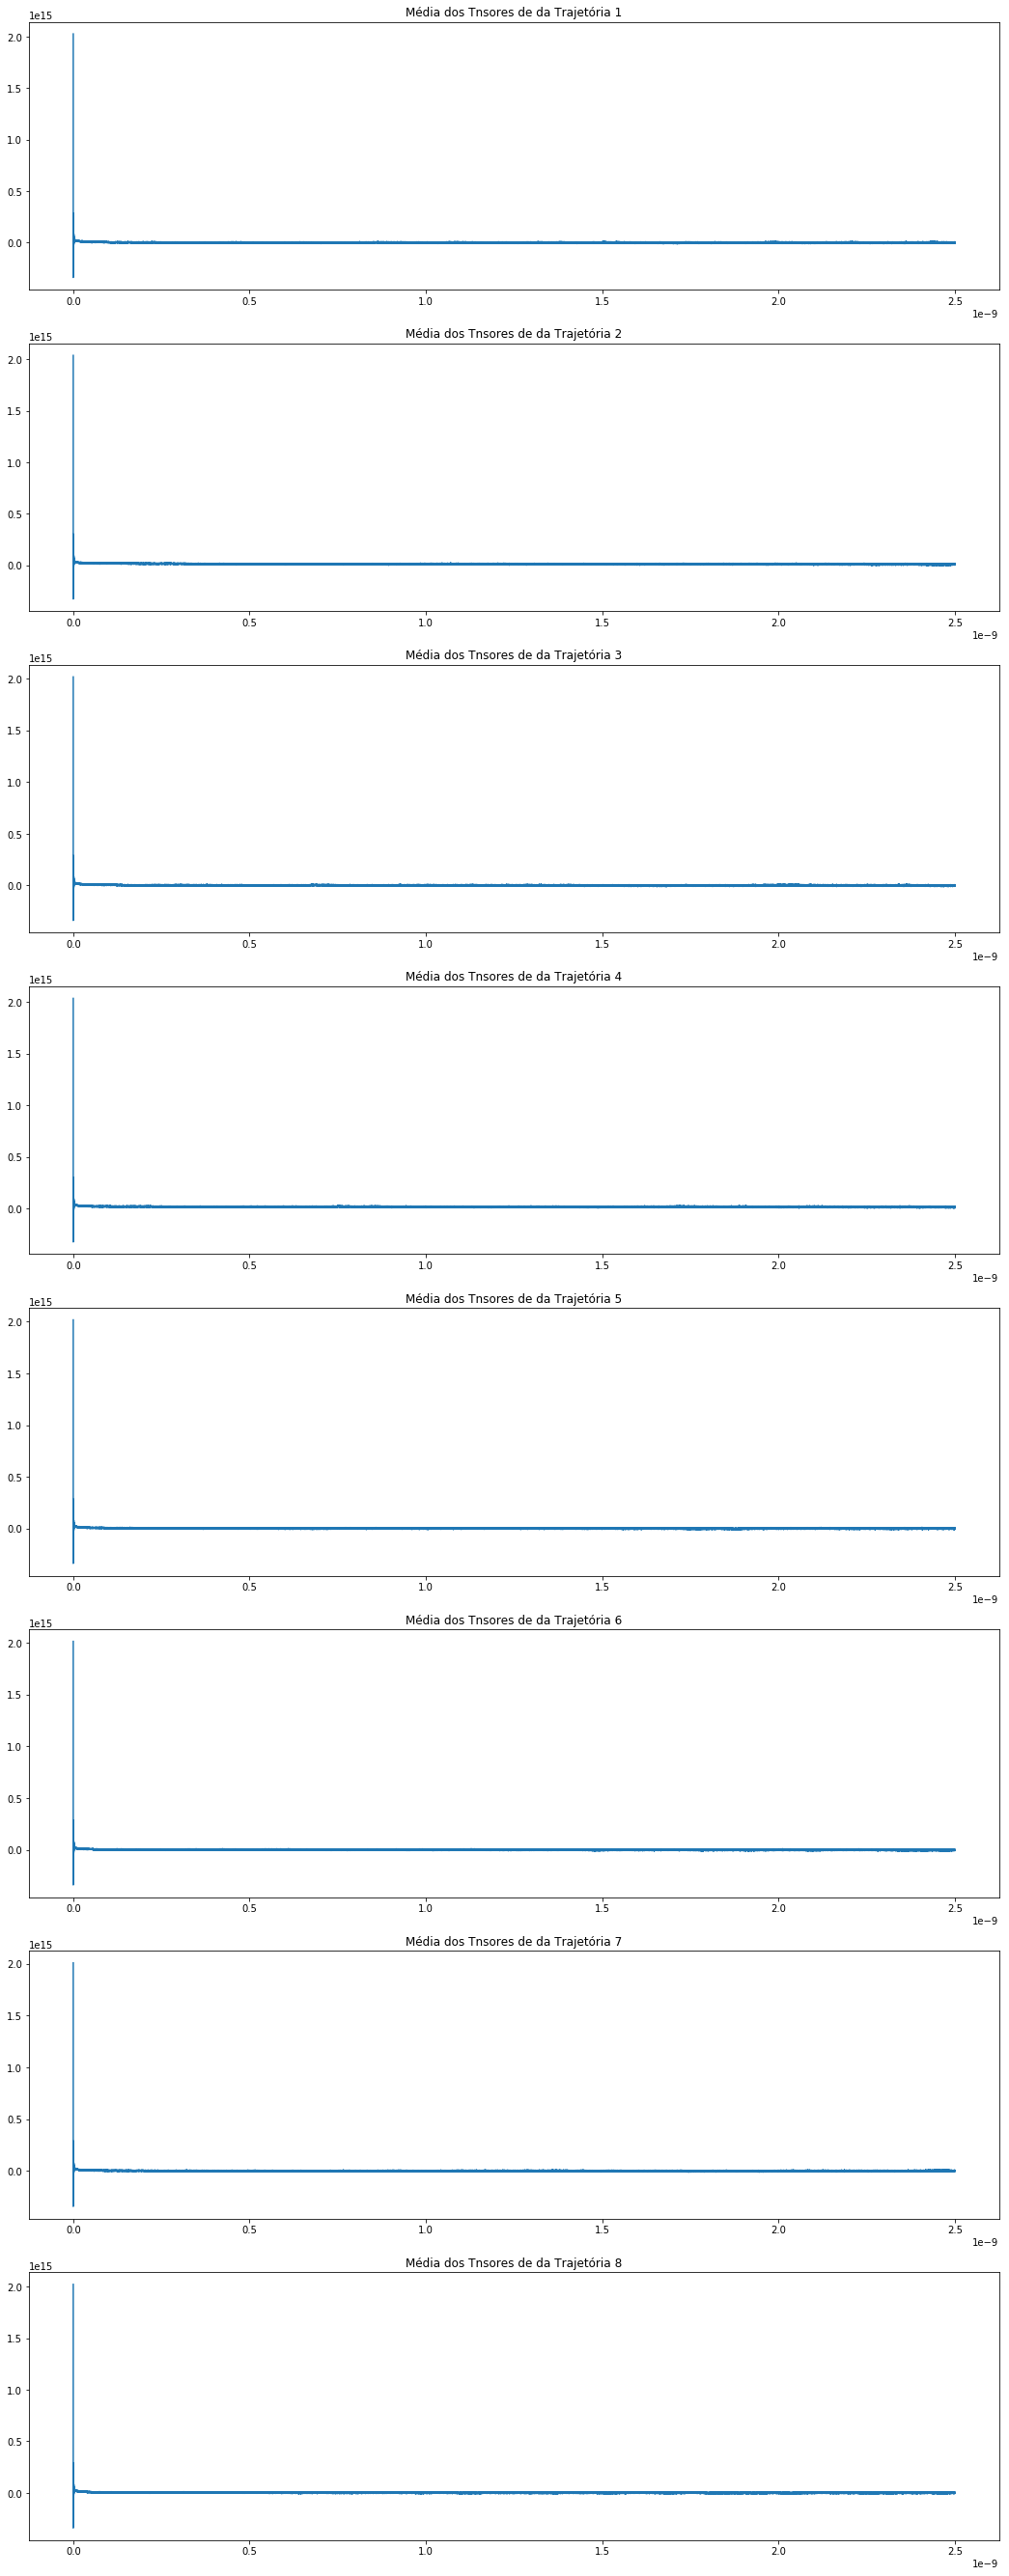

In [12]:
n_traj = len(x_averages)
fig, ax = plt.subplots(nrows=n_traj, ncols=1, figsize=(18,6*n_traj))
plt.rcParams['agg.path.chunksize'] = 10000
for i in range(n_traj):
    ax[i].plot(x_averages[i],y_averages[i])
    ax[i].set_title('Média dos Tnsores de da Trajetória {}'.format(trajs[i]))
plt.show()

Olhando em escala normal parece que todas convergem, mas vamos examiná-las em escala logarítmica.

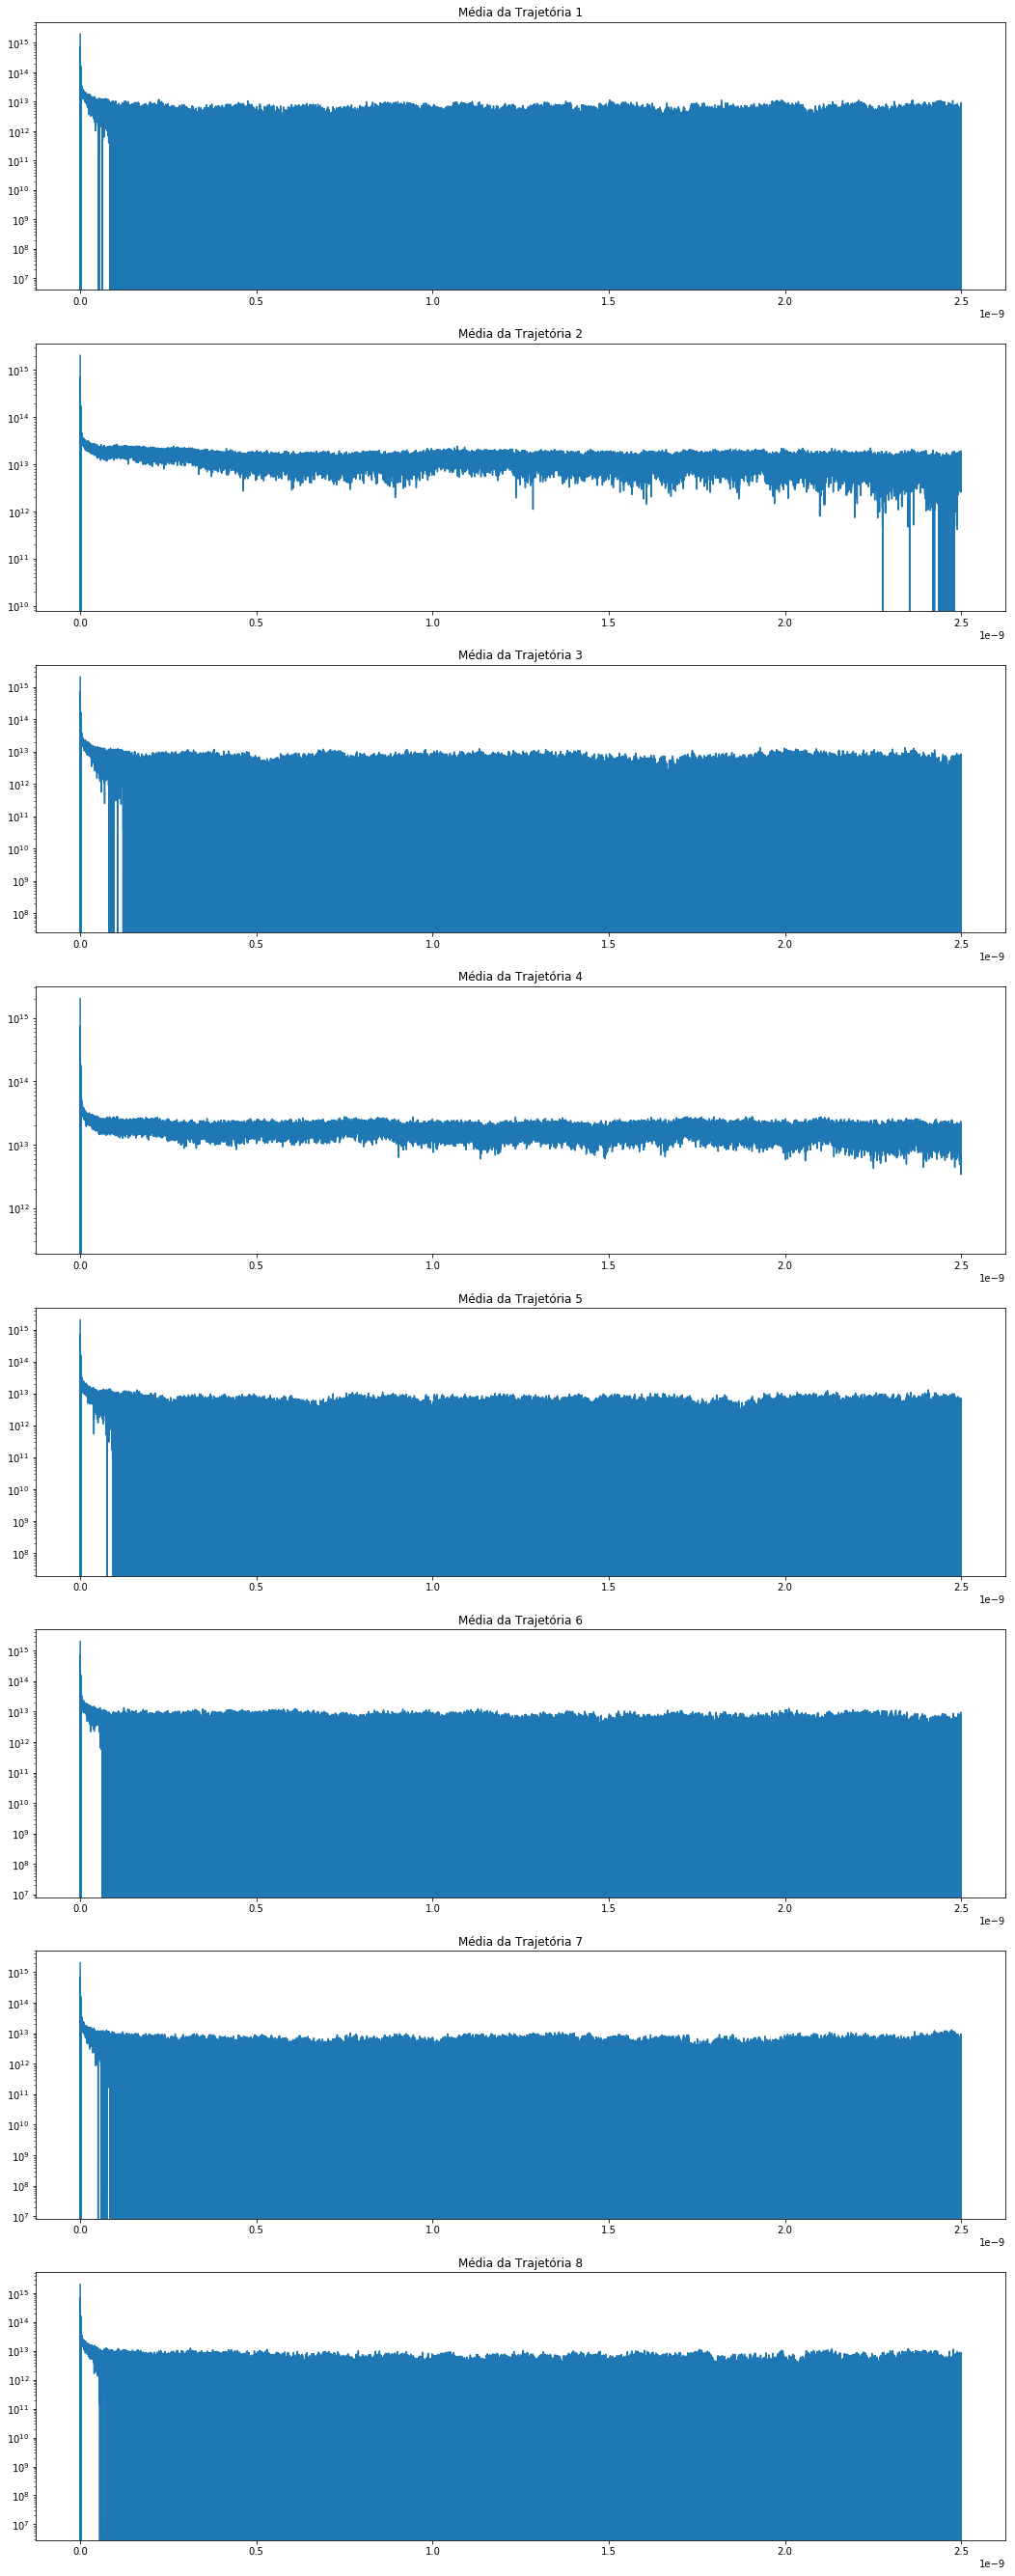

In [13]:
n_traj = len(x_averages)
fig, ax = plt.subplots(nrows=n_traj, ncols=1, figsize=(18,6*n_traj))
plt.rcParams['agg.path.chunksize'] = 10000
for i in range(n_traj):
    ax[i].semilogy(x_averages[i], y_averages[i])
    ax[i].set_title('Média da Trajetória {}'.format(trajs[i]))
plt.show()

Nessa escala podemos ver que as trajetórias $2$ e $4$ não convergem, pois seus valores não estão oscilando em torno de $0$, estão oscilando em torno de algum valor maior que $0$. Então descartaremos estas.

In [14]:
trajs_list = list(trajs)
try:
    assert len(trajs) == len(x_averages)
    assert len(trajs) == n0_trajs
    indices_descarte = [trajs_list.index(2), trajs_list.index(4)]

    trajs = np.delete(trajs, indices_descarte)
    x_averages = np.delete(x_averages,indices_descarte,axis=0)
    y_averages = np.delete(y_averages,indices_descarte,axis=0)
except Exception as e:
    logger.error('Essas trajetórias já foram retiradas: '+str(e))

In [15]:
print('Usaremos apenas as trajetórias',trajs,'. Pois foram as únicas que convergiram.')

Usaremos apenas as trajetórias [1 3 5 6 7 8] . Pois foram as únicas que convergiram.


Abaixo, os gráficos das trajetórias que usaremos.

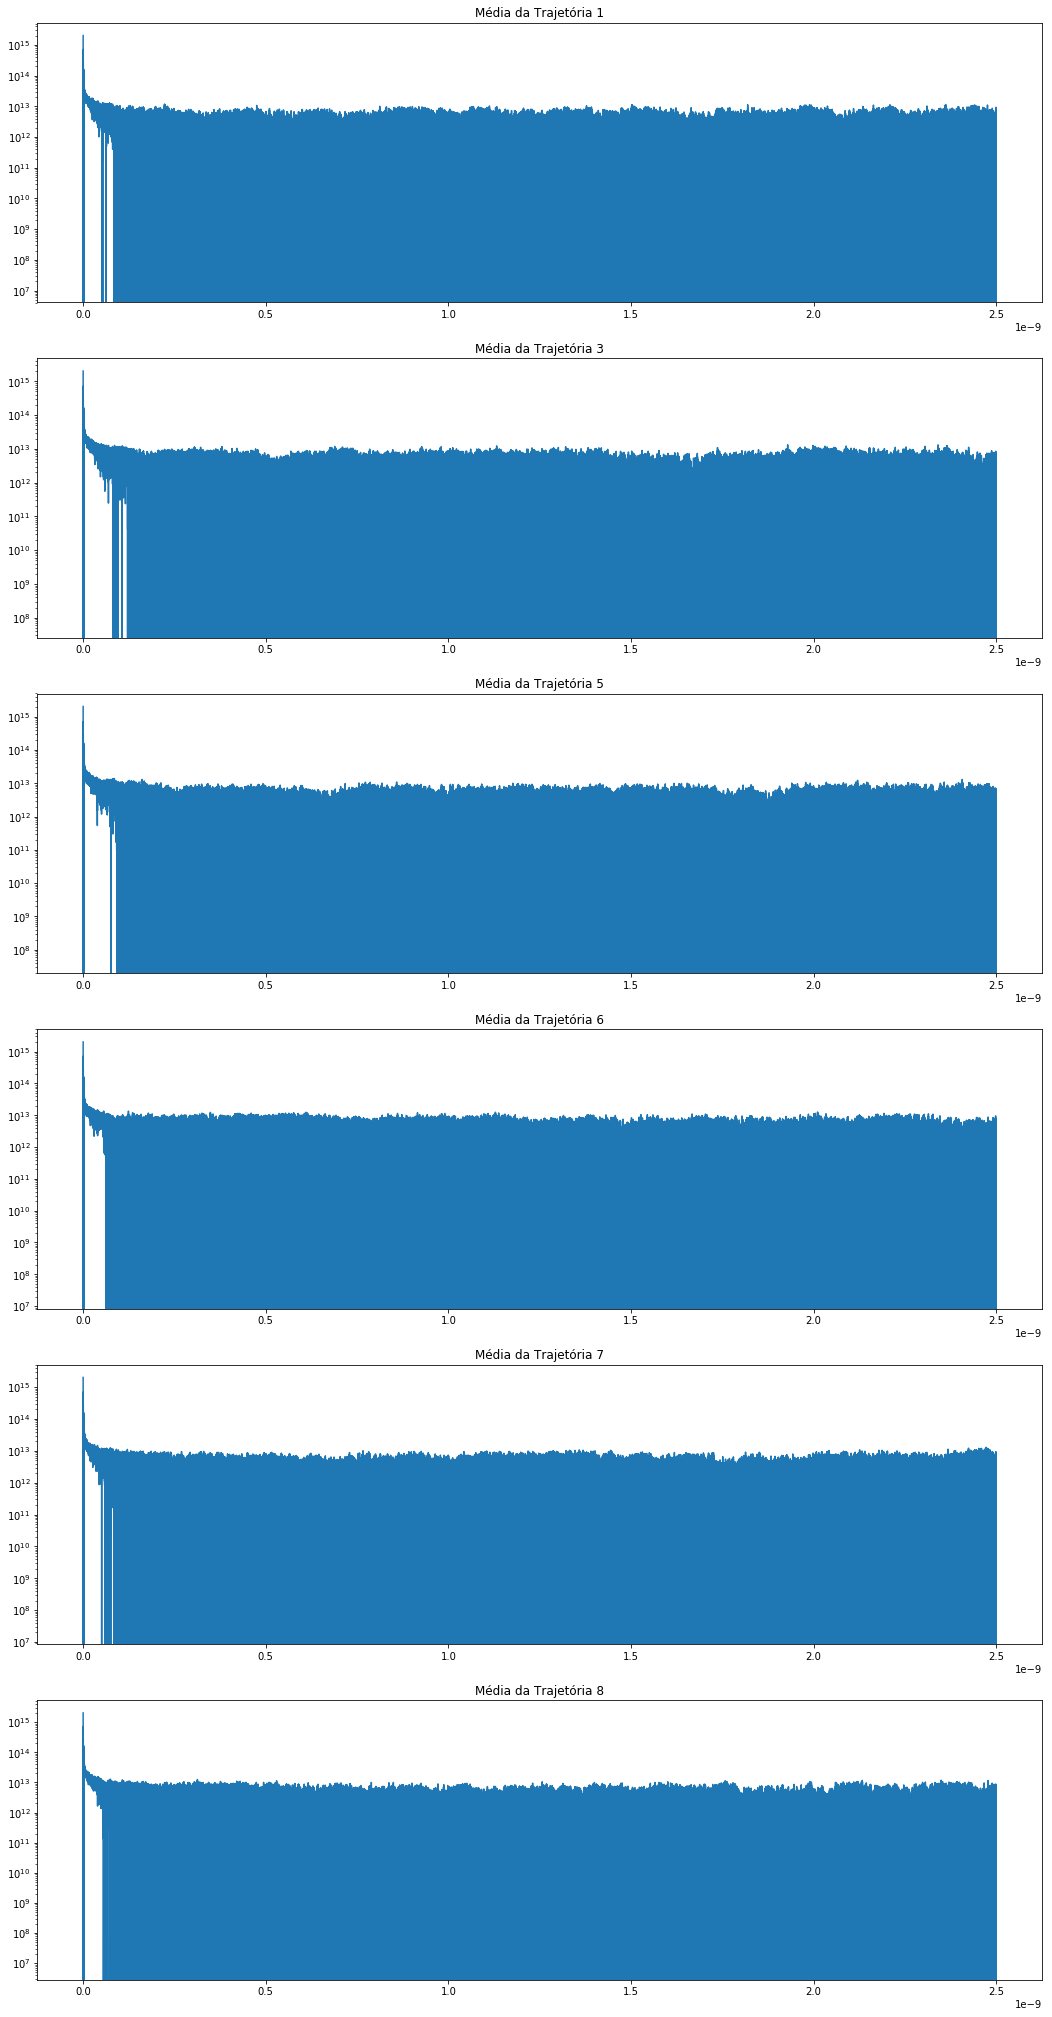

In [16]:
n_traj = len(x_averages)
fig, ax = plt.subplots(nrows=n_traj, ncols=1, figsize=(18,6*n_traj))
plt.rcParams['agg.path.chunksize'] = 10000
for i in range(n_traj):
    ax[i].semilogy(x_averages[i], y_averages[i])
    ax[i].set_title('Média da Trajetória {}'.format(trajs[i]))
plt.show()

#### (2) Para cada trajetória, calcule a viscosidade de cisalhamento com base na relação Green-Kubo (eq 1):

[Voltar ao índice das etapas](#Procedimento-de-5-etapas-para-o-Cálculo-da-Viscosidade-pelo-Método-Maginn)

A relação Green-Kubo é defenida como:

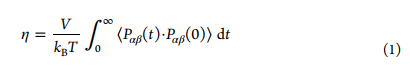

In [17]:
Image("Images/primeira_pagina_do_artigo_p2.png")

Em que:
- $\eta$ é a viscosidade;
- $V$ é o Volume do sistema; 
- $k_b$ é a constante de Boltzmann;
- $T$ é a temperatura do sistema;
- $P_{\alpha \beta}$ denota o elemento $\alpha \beta$ do tensor de pressão, e o colchete angular indica a média do conjunto.

Todos em SI(Sistema Internacioal de unidades)

In [18]:
def green_kubo(V,kb,T,xs,ys,step=1000):
    N = [] 
    for i in range(1,len(xs),step):
        I = simps(ys[:i],xs[:i])
        
        n = V/(kb*T) * I
        n = n*1e+3 #convertendo de Pa.s para cP
        N.append(n)
    
    return np.array(N)

Vamos então usar essa relação para calcular a viscosidade de cada uma das trajetórias e colocar todas no array $N_s$

In [19]:
# lista de viscosidades
Ns = [] 
step=1000

for i in range(len(trajs)):
    ni = green_kubo(V,kb,T,x_averages[i],y_averages[i],step)
    Ns.append(ni)
    
Ns = np.array(Ns)

Plotando as viscosidades calculadas.

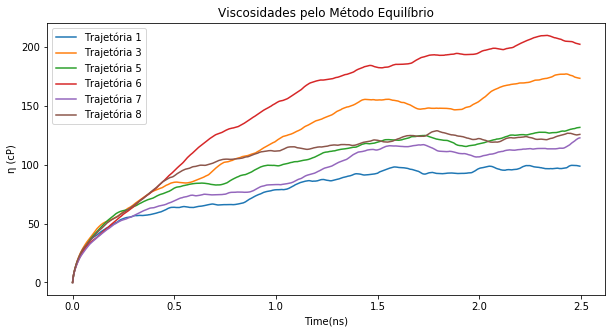

In [20]:
ts = x_averages[0][1::step]*1e+9

plt.figure(figsize=(10,5))
for i in range(len(Ns)):
    plt.plot(ts,Ns[i],label='Trajetória {}'.format(trajs[i]))

plt.title('Viscosidades pelo Método Equilíbrio')
plt.xlabel('Time(ns)')
plt.ylabel('\u03B7 (cP)')
plt.legend()
plt.show()

#### (3) Calcular a média das integrais em execução sobre N trajetórias ⟨$\eta$(t)⟩ e o desvio padrão, que é uma função do tempo:

[Voltar ao índice das etapas](#Procedimento-de-5-etapas-para-o-Cálculo-da-Viscosidade-pelo-Método-Maginn)

##### Viscosidade Média

In [21]:
#Viscosidade Média
Ns_average = np.average(Ns,axis=0)

Plotando as integrais das trajetórias e sua média

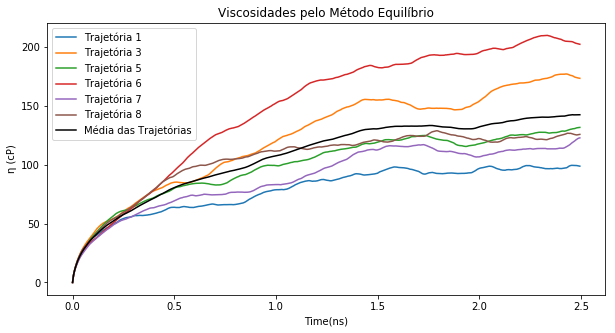

In [22]:
plt.figure(figsize=(10,5))
for i in range(len(Ns)):
    plt.plot(ts,Ns[i],label='Trajetória {}'.format(trajs[i]))


plt.plot(ts,Ns_average, 'black',label='Média das Trajetórias')
plt.title('Viscosidades pelo Método Equilíbrio')
plt.xlabel('Time(ns)')
plt.ylabel('\u03B7 (cP)')

plt.legend()
plt.show()

##### Desvio Padrão

In [23]:
#Calculo do desvio padrão
st_des = np.std(Ns,axis=0)

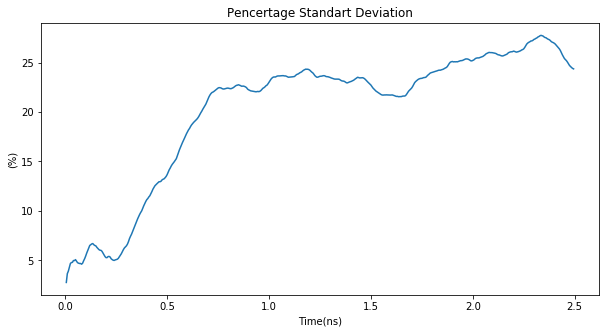

In [24]:
plt.figure(figsize=(10,5))
st_des_perc = st_des[1:]/Ns_average[1:]*100 #Porcentagem do Desvio Padrão
plt.plot(ts[1:],st_des_perc)
plt.xlabel('Time(ns)')
plt.ylabel('(%)')
plt.title('Pencertage Standart Deviation')

plt.show()

In [25]:
print('O Desvio Padrão percentual máximo dessa amostra é {0:.2f}%.'.format(max(st_des_perc)))

O Desvio Padrão percentual máximo dessa amostra é 27.76%.


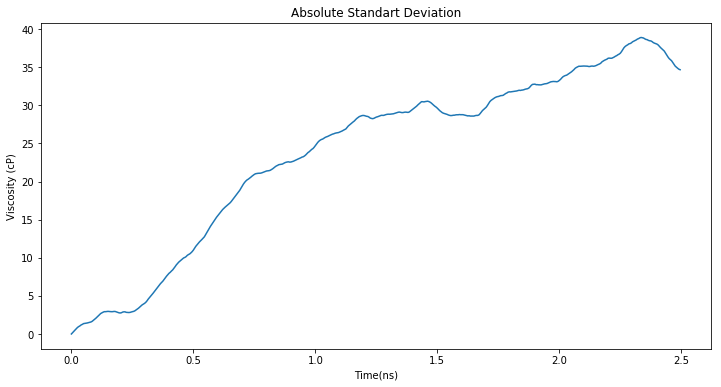

In [26]:
plt.figure(figsize=(12,6))
plt.plot(ts,st_des)
plt.xlabel('Time(ns)')
plt.ylabel('Viscosity (cP)')
plt.title('Absolute Standart Deviation')

plt.show()

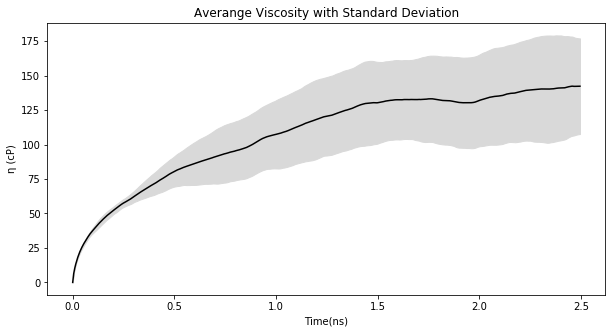

In [27]:
plt.figure(figsize=(10,5))
plt.plot(ts,Ns_average,'black')
plt.fill_between(ts,Ns_average - st_des, Ns_average + st_des,color='0.85')
plt.title('Averange Viscosity with Standard Deviation')
plt.xlabel('Time(ns)')
#plt.ylabel('\u03C1 (cP)')
plt.ylabel('\u03B7 (cP)')

plt.show()

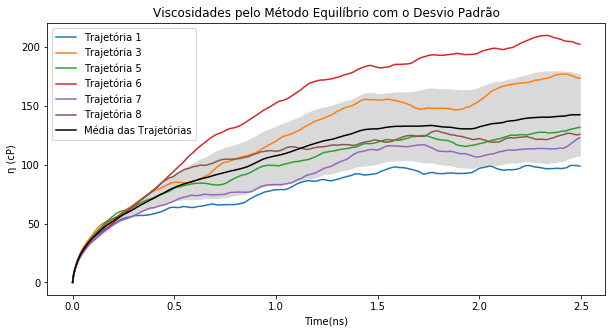

In [28]:
plt.figure(figsize=(10,5))
for i in range(len(Ns)):
    plt.plot(ts,Ns[i],label='Trajetória {}'.format(trajs[i]))

plt.plot(ts,Ns_average, 'black',label='Média das Trajetórias')
plt.fill_between(ts,Ns_average - st_des, Ns_average + st_des,color='0.85')
plt.title('Viscosidades pelo Método Equilíbrio com o Desvio Padrão')
plt.xlabel('Time(ns)')
#plt.ylabel('\u03C1 (cP)')
plt.ylabel('\u03B7 (cP)')

plt.legend()
plt.show()

#### (4) Ajuste o desvio padrão para uma função de lei de potência:

\begin{equation}
    \sigma(t) = At^{b}
\end{equation}

[Voltar ao índice das etapas](#Procedimento-de-5-etapas-para-o-Cálculo-da-Viscosidade-pelo-Método-Maginn)


Usaremos esse ajuste na [etapa (5)]()

In [29]:
def fit_desvio(t,A,b):
    return A*t**b

In [30]:
# Encontrar os parâmetros do ajuste do desvio padrão usando o curve_fit
res = curve_fit(fit_desvio,ts,st_des),
res

((array([21.77340782,  0.66988543]), array([[ 0.02160179, -0.00115061],
         [-0.00115061,  0.00010831]])),)

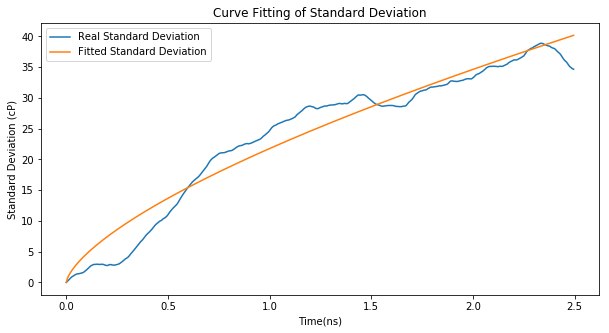

In [31]:
A, b = res[0][0]
fit_des = fit_desvio(ts,A,b)
plt.figure(figsize=(10,5))
plt.plot(ts,st_des,label='Real Standard Deviation')
plt.plot(ts,fit_des,label='Fitted Standard Deviation')

plt.title('Curve Fitting of Standard Deviation')
plt.legend()
plt.xlabel('Time(ns)')
plt.ylabel('Standard Deviation (cP)')
plt.show()

##### (5) Ajustar a integral média em execução pela função dupla - exponencial (eq2) para o período de tempo até $t_{cut}$, que pode ser decidido a partir da relação entre $ \eta$ e $ \sigma(t) $. Descobrimos que o tempo em que $ \sigma(t)$ é cerca de 40% de $<\eta(t)>$ é uma boa escolha. Pegue o valor do limite com tempo tendendo a infinito da função double-exponencial ajustada a viscosidade calculada:

Esse comentário sobre o desvio padrão de $40\%$ é do autor do artigo.

[Voltar ao índice das etapas](#Procedimento-de-5-etapas-para-o-Cálculo-da-Viscosidade-pelo-Método-Maginn)

##### Função Double-Exponencial

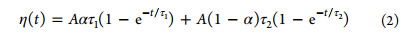

In [32]:
Image("Images/visc_fit.png")

In [33]:
def doubexp(x,A,alpha,tau1, tau2):
    return A*alpha*tau1*(1-np.exp(-x/tau1))+A*(1-alpha)*tau2*(1-np.exp(-x/tau2))

Viscosidade Calculada:

In [34]:
visc = Ns_average

In [35]:
len(visc)

500

##### Tempo $t_{cut}:$

É a marcação de tempo que escolhemos para manter o desvio padrão sobre controle. Como o desvio padrão dos dados tende a aumentar ao longo do tempo, determinamos qual a tolerância de desvio padrão que queremos usar (o autor recomendo $40\%$ para casos gerais) e usaremos os dados até o momento em que o desvio possui o valor que determinamos, descartando os dados subsequentes, em que o desvio é maior. 

Depois de determinarmo do $t_{cut}$ vamos ajustar a [função double-exponencial](#Fun%C3%A7%C3%A3o-Double-Exponencial) a viscosidade média calculada.

Como o desvio padrão oscila um pouco ao longo do tempo, determinaremos o $t_{cut}$ usando o [desvio padrão ajustado](#(4)-Ajuste-o-desvio-padrão-para-uma-função-de-lei-de-potência:), para ter uma maior estabilidade.

In [36]:
def time_cut(Ns_average, st_des, tol_std_perc=0.4):
    foundcutoff = False
    time_cut = 1
    while not foundcutoff and time_cut<len(Ns_average):
        if st_des[time_cut] > tol_std_perc*Ns_average[time_cut]:
            foundcutoff = True
        else:
            time_cut += 1
            
    return time_cut

In [37]:
sigma = 0.4

cut = time_cut(Ns_average, st_des, tol_std_perc=sigma)
cut

500

Agora faremos o ajuste da função a viscosidade calculada

In [38]:
popt3,pcov2 = curve_fit(doubexp, ts[1:cut],visc[1:cut],
                                 sigma=st_des[1:cut],
                                 bounds=(0,[np.inf,1,np.inf,np.inf]),maxfev=1000000)

In [39]:
popt3

array([1.29633074e+03, 8.65155081e-01, 1.82864028e-02, 6.78393639e-01])

In [40]:
pcov2

array([[ 1.20174369e+02,  6.33389708e-03, -2.97272805e-03,
        -3.24030781e-02],
       [ 6.33389708e-03,  2.25207739e-06,  3.29833350e-08,
         1.07176400e-05],
       [-2.97272805e-03,  3.29833350e-08,  1.00541619e-07,
         1.86962151e-06],
       [-3.24030781e-02,  1.07176400e-05,  1.86962151e-06,
         1.09896206e-04]])

In [41]:
print('Os parâmetros do ajuste são', popt3)

Os parâmetros do ajuste são [1.29633074e+03 8.65155081e-01 1.82864028e-02 6.78393639e-01]


Agora, usaremos a função ajustada

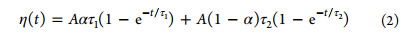

In [42]:
Image("Images/visc_fit.png")

E para saber para qual valor essa função converge, calcularemos seu limite quando o tempo t tende ao infinito.

O resultado da viscosidade nesse limite vale:

\begin{equation}
    \eta = A \alpha \tau_1 + A(1-\alpha)\tau_2
\end{equation}

In [43]:
visc_final = popt3[0]*popt3[1]*popt3[2]+popt3[0]*(1-popt3[1])*popt3[3]
print('viscosity: {0:.5f}'.format(visc_final) + ' cP')

viscosity: 139.09436 cP


Para verificar se estamos no caminho certo, compararemos a viscosidade calculada, sob as mesmas condições, por experimentos laboratoriais (não por simulações).

A viscosidade experimental é $(115\pm 29)$

*Referência: Florindo et al, Chem. Comm., 2018*

In [44]:
#experimental viscosity
visc_exp = 115
tol = 29

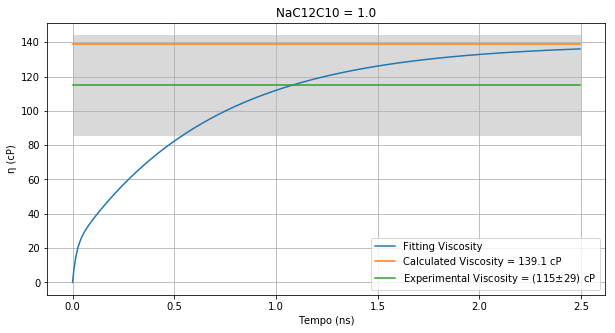

In [45]:
plt.figure(figsize=(10,5))
#plt.plot(ts[:cut]*1e+9,visc[:cut],'o',label='Real Viscosity')

plt.plot(ts[:cut],doubexp(ts[:cut],*popt3),label='Fitting Viscosity')
plt.plot(ts[:cut],visc_final*np.ones_like(visc[:cut]),label='Calculated Viscosity = {:.1f} cP'.format(visc_final))
plt.plot(ts[:cut],  visc_exp*np.ones_like(visc[:cut]),label='Experimental Viscosity = ({}$\pm${}) cP'.format(visc_exp,tol))
plt.fill_between(ts[:cut], (visc_exp - tol)*np.ones_like(visc[:cut]), (visc_exp + tol)*np.ones_like(visc[:cut]), color='0.85')

plt.grid()
plt.title('NaC12C10 = 1.0')
plt.xlabel('Tempo (ns)')
plt.ylabel('\u03B7 (cP)')
plt.legend()
plt.show()

##### Conclusão:
Finalmente, 

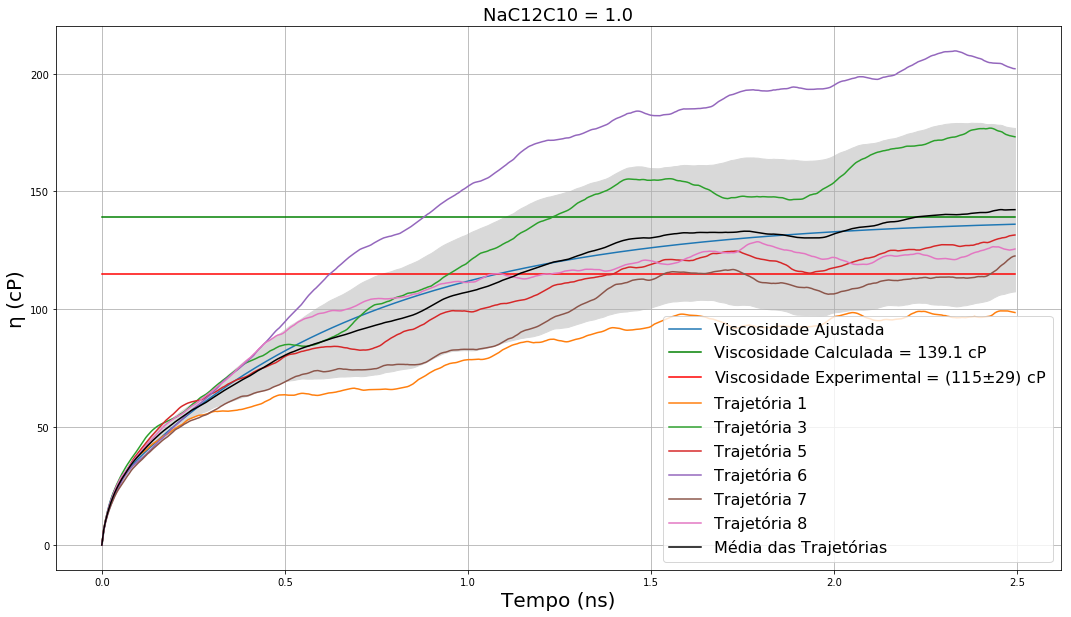

In [46]:
plt.figure(figsize=(18,10))

plt.grid()
#plt.plot(ts[:cut],visc[:cut],'o',label='Real Viscosity')
plt.plot(ts[:cut],doubexp(ts[:cut],*popt3),label='Viscosidade Ajustada')
plt.plot(ts[:cut],visc_final*np.ones_like(visc[:cut]),label='Viscosidade Calculada = {:.1f} cP'.format(visc_final),color='g')

plt.plot(ts[:cut],  visc_exp*np.ones_like(visc[:cut]),label='Viscosidade Experimental = ({}$\pm${}) cP'.format(visc_exp,tol),color='r')


for i in range(len(Ns)):
    plt.plot(ts[:cut],Ns[i][:cut],label='Trajetória {}'.format(trajs[i]))

plt.plot(ts[:cut],Ns_average[:cut], 'black',label='Média das Trajetórias')
plt.fill_between(ts[:cut], Ns_average[:cut] - st_des[:cut], Ns_average[:cut] + st_des[:cut], color='0.85')


plt.title('NaC12C10 = 1.0', fontsize=18)
plt.xlabel('Tempo (ns)',fontsize=20)
plt.ylabel('\u03B7 (cP)',fontsize=20)
plt.legend(prop={'size':16})
plt.show()

Repare que esses são os resultados se seguirmos a recomendação do autor do artigo de usar uma tolerância de desvio padrão de $40\%$, mas o desvio padrão máximo das nossas trajetórias é menor que $30\%$, então talvez possamos conseguir resultados melhores se diminuirmos essa tolerância.

Vamos esperimentar o quanto a diferença entre a viscosidade calculada e a viscosidade experimental mudam conforme variamos a tolerância.

#### Variação da Viscosidade Calculada e do erro conforme a variação da tolerância do desvio padrão



In [47]:
tcuts = []
viscs_finais = []
popt3s = []
sigmas = np.array(range(0,101))/100
print('Calculating for:')
for sigma in sigmas:
    print('\tsigma = {}%'.format(sigma*100))
    cut = time_cut(Ns_average, st_des, tol_std_perc=sigma)
    tcuts.append(cut)
    
    try:
        popt3,pcov2 = curve_fit(doubexp, ts[1:cut],visc[1:cut],
                                sigma=st_des[1:cut],
                                bounds=(0,[np.inf,1,np.inf,np.inf]),maxfev=1000000)
        visc_final = popt3[0]*popt3[1]*popt3[2]+popt3[0]*(1-popt3[1])*popt3[3]
        
        popt3s.append(popt3)
        viscs_finais.append(visc_final)
    except:
        viscs_finais.append(0)
    

popt3s = np.array(popt3s)
viscs_finais = np.array(viscs_finais)
tcuts = np.array(tcuts)

Calculating for:
	sigma = 0.0%
	sigma = 1.0%
	sigma = 2.0%
	sigma = 3.0%


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


	sigma = 4.0%
	sigma = 5.0%
	sigma = 6.0%
	sigma = 7.000000000000001%
	sigma = 8.0%
	sigma = 9.0%
	sigma = 10.0%
	sigma = 11.0%
	sigma = 12.0%
	sigma = 13.0%
	sigma = 14.000000000000002%
	sigma = 15.0%
	sigma = 16.0%
	sigma = 17.0%
	sigma = 18.0%
	sigma = 19.0%
	sigma = 20.0%
	sigma = 21.0%
	sigma = 22.0%
	sigma = 23.0%
	sigma = 24.0%
	sigma = 25.0%
	sigma = 26.0%
	sigma = 27.0%
	sigma = 28.000000000000004%
	sigma = 28.999999999999996%
	sigma = 30.0%
	sigma = 31.0%
	sigma = 32.0%
	sigma = 33.0%
	sigma = 34.0%
	sigma = 35.0%
	sigma = 36.0%
	sigma = 37.0%
	sigma = 38.0%
	sigma = 39.0%
	sigma = 40.0%
	sigma = 41.0%
	sigma = 42.0%
	sigma = 43.0%
	sigma = 44.0%
	sigma = 45.0%
	sigma = 46.0%
	sigma = 47.0%
	sigma = 48.0%
	sigma = 49.0%
	sigma = 50.0%
	sigma = 51.0%
	sigma = 52.0%
	sigma = 53.0%
	sigma = 54.0%
	sigma = 55.00000000000001%
	sigma = 56.00000000000001%
	sigma = 56.99999999999999%
	sigma = 57.99999999999999%
	sigma = 59.0%
	sigma = 60.0%
	sigma = 61.0%
	sigma = 62.0%
	sigma = 63.0

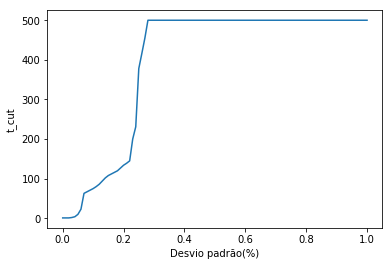

In [48]:
plt.plot(sigmas,tcuts)
plt.xlabel('Desvio padrão(%)')
plt.ylabel('t_cut')
plt.show()

Repare que após o valor do sigma ultrapassar o valor máximo do desvio padrão dessa amostra, ele passa a usar todos os pontos disponíveis, e o $t_{cut}$ passa a ser o ponto final.

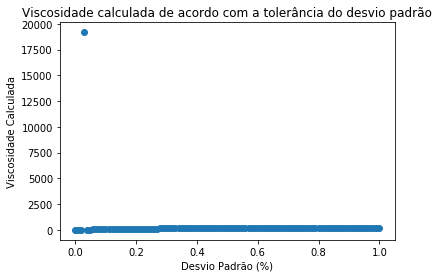

In [49]:
plt.plot(sigmas,viscs_finais,'o')
plt.title('Viscosidade calculada de acordo com a tolerância do desvio padrão')
plt.xlabel('Desvio Padrão (%)')
plt.ylabel('Viscosidade Calculada')
plt.show()

Afim de evitar outliers, se menos de $5\%$ dos pontos estiverem a mais de duas vezes o desvião padrão, serão considerados outliers.

In [50]:
def exist_outliers(data, tol=0.05):
    average = np.average(data)
    std = np.std(data)
    n = len(data)
    out = 0
    
    for e in data:
        if abs(e-average) > 2*std:
            out+=1
    if out/n <= tol:
        return True
    else: 
        return False
    
def index_outliers(data,tol=0.05):
    data = np.array(data)
    average = np.average(data)
    std = np.std(data)
    n = len(data)
    index = []
    
    for i in range(len(data)):
        if abs(data[i]-average) >= 2*std:
            index.append(i)
    
    return np.array(index)

In [51]:
exist_outliers(viscs_finais)

True

In [52]:
index_outliers(viscs_finais)

array([3])

In [53]:
while exist_outliers(viscs_finais):
    index_out = index_outliers(viscs_finais)
    viscs_finais = np.delete(viscs_finais,index_out)
    sigmas = np.delete(sigmas,index_out)

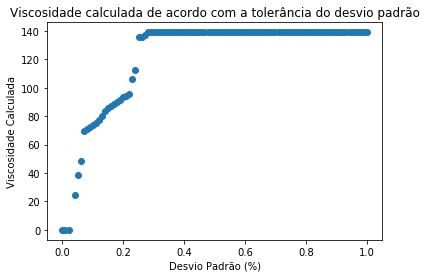

In [54]:
plt.plot(sigmas,viscs_finais,'o')
plt.title('Viscosidade calculada de acordo com a tolerância do desvio padrão')
plt.xlabel('Desvio Padrão (%)')
plt.ylabel('Viscosidade Calculada')
plt.show()

In [55]:
err = viscs_finais - visc_exp
err

array([-115.        , -115.        , -115.        ,  -90.64324501,
        -76.45964373,  -66.24488141,  -45.04779272,  -43.77557673,
        -42.52197267,  -41.27664803,  -39.69573693,  -37.71479538,
        -34.78455725,  -31.3697577 ,  -28.9716514 ,  -27.50870539,
        -26.23298714,  -25.09019342,  -23.31931094,  -21.73894385,
        -20.73123366,  -19.62853546,   -9.11233909,   -2.80362785,
         20.55278775,   21.05741142,   22.45276067,   24.09435585,
         24.09435585,   24.09435585,   24.09435585,   24.09435585,
         24.09435585,   24.09435585,   24.09435585,   24.09435585,
         24.09435585,   24.09435585,   24.09435585,   24.09435585,
         24.09435585,   24.09435585,   24.09435585,   24.09435585,
         24.09435585,   24.09435585,   24.09435585,   24.09435585,
         24.09435585,   24.09435585,   24.09435585,   24.09435585,
         24.09435585,   24.09435585,   24.09435585,   24.09435585,
         24.09435585,   24.09435585,   24.09435585,   24.09435

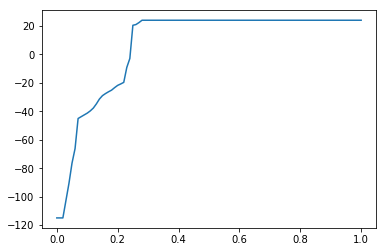

In [56]:
plt.plot(sigmas,err)
plt.show()

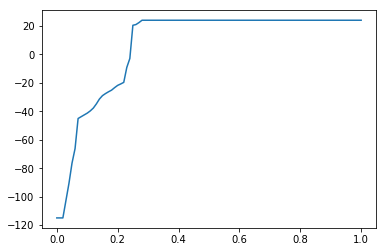

In [57]:
plt.plot(sigmas,err)
plt.show()

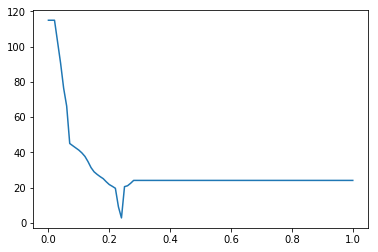

In [58]:
plt.plot(sigmas,abs(err))
plt.show()

In [59]:
mini=min(abs(err))
opt, = np.where(abs(err)==mini)[0]
print('O sigma de menor erro é com o desvio padrão de {}%.'.format(sigmas[opt]*100))

O sigma de menor erro é com o desvio padrão de 24.0%.


In [60]:
opt

23

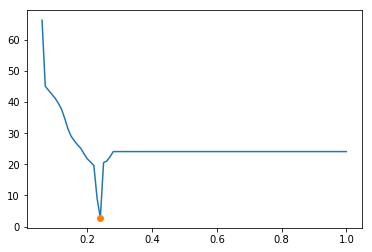

In [61]:
plt.plot(sigmas[5:],abs(err[5:]))
plt.plot(sigmas[opt],abs(err[opt]),'o')

##### Conclusão Otimizada

Portanto, após todo esse processo, a viscosidade que chegamos é 

In [62]:
viscs_finais[opt]

112.19637214526321

Com um erro de

In [63]:
err[opt]

-2.8036278547367885

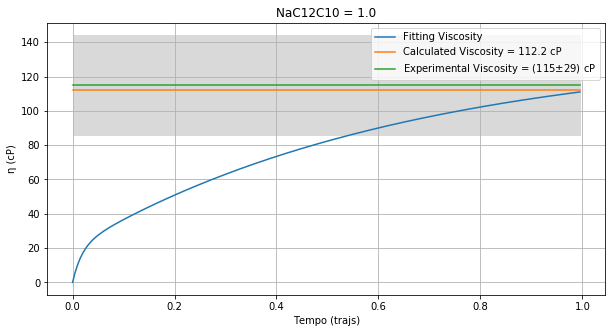

In [64]:
plt.figure(figsize=(10,5))
#plt.plot(ts[:cut]*1e+9,visc[:cut],'o',label='Real Viscosity')

plt.plot(ts[:tcuts[opt]],doubexp(ts[:tcuts[opt]],*popt3s[opt]),label='Fitting Viscosity')
plt.plot(ts[:tcuts[opt]],viscs_finais[opt]*np.ones_like(visc[:tcuts[opt]]),label='Calculated Viscosity = {:.1f} cP'.format(viscs_finais[opt]))
plt.plot(ts[:tcuts[opt]],  visc_exp*np.ones_like(visc[:tcuts[opt]]),label='Experimental Viscosity = ({}$\pm${}) cP'.format(visc_exp,tol))
plt.fill_between(ts[:tcuts[opt]], (visc_exp - tol)*np.ones_like(visc[:tcuts[opt]]), (visc_exp + tol)*np.ones_like(visc[:tcuts[opt]]), color='0.85')

plt.grid()
plt.title('NaC12C10 = 1.0')
plt.xlabel('Tempo (trajs)')
plt.ylabel('\u03B7 (cP)')
plt.legend()
plt.show()

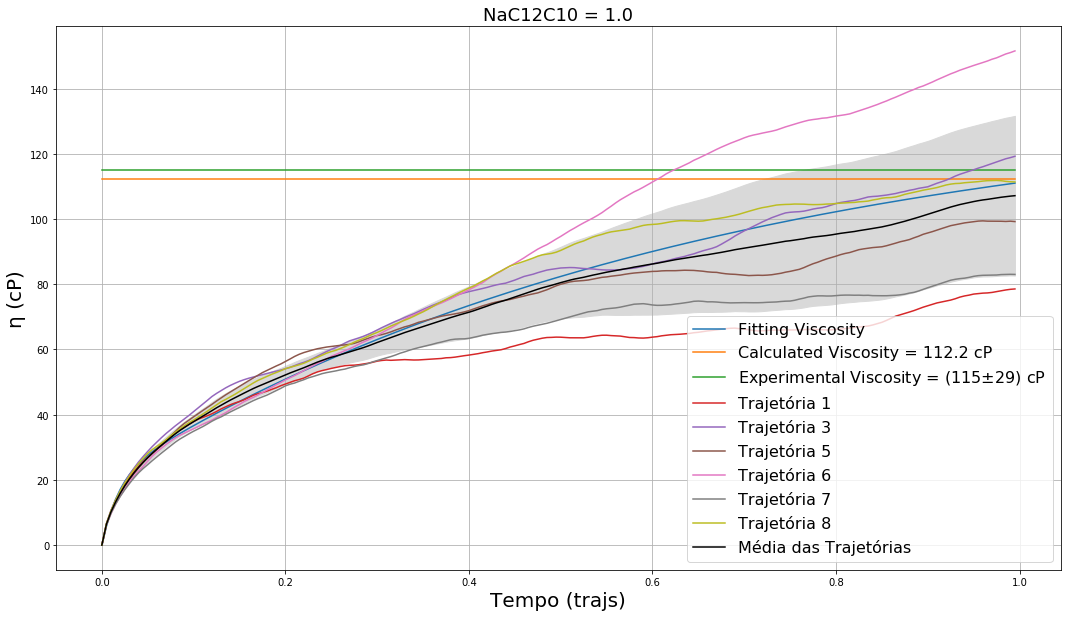

In [65]:
plt.figure(figsize=(18,10))

plt.grid()
#plt.plot(ts[:cut],visc[:cut],'o',label='Real Viscosity')
plt.plot(ts[:tcuts[opt]],doubexp(ts[:tcuts[opt]],*popt3s[opt]),label='Fitting Viscosity')
plt.plot(ts[:tcuts[opt]],viscs_finais[opt]*np.ones_like(visc[:tcuts[opt]]),label='Calculated Viscosity = {:.1f} cP'.format(viscs_finais[opt]))
plt.plot(ts[:tcuts[opt]],  visc_exp*np.ones_like(visc[:tcuts[opt]]),label='Experimental Viscosity = ({}$\pm${}) cP'.format(visc_exp,tol))

for i in range(len(Ns)):
    plt.plot(ts[:tcuts[opt]],Ns[i][:tcuts[opt]],label='Trajetória {}'.format(trajs[i]))

plt.plot(ts[:tcuts[opt]],Ns_average[:tcuts[opt]], 'black',label='Média das Trajetórias')
plt.fill_between(ts[:tcuts[opt]], Ns_average[:tcuts[opt]] - st_des[:tcuts[opt]], Ns_average[:tcuts[opt]] + st_des[:tcuts[opt]], color='0.85')


plt.title('NaC12C10 = 1.0', fontsize=18)
plt.xlabel('Tempo (trajs)',fontsize=20)
plt.ylabel('\u03B7 (cP)',fontsize=20)
plt.legend(prop={'size':16})
plt.show()

In [66]:
!jupyter nbconvert Calculo_da_Viscosidade.ipynb --to slides --SlidesExporter.reveal_scroll=True --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook Calculo_da_Viscosidade.ipynb to slides
[NbConvertApp] Writing 3094986 bytes to Calculo_da_Viscosidade.slides.html
